## CE888 - Data Science and Decision Making

## AN INVESTIGATION OF ASSESSMENT OF EMPATHY USING EYE TRACKING DATA

#### REGISTRATION NUMBER - 2204809

#### Importing the required libraries 

In [144]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
np.set_printoptions(precision = 3)
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from math import sqrt

#### Helper functions 

In [2]:
#function to merge the dataset
def merge_csv(directory):
    files = os.listdir(directory)
    data = pd.DataFrame()
    for file in files:
        if file.endswith('.csv'):
            data = pd.concat([data, pd.read_csv(os.path.join(directory, file), usecols=["Computer timestamp", "Participant name", 'Recording name','Gaze point X','Gaze point Y', 'Pupil diameter left', 'Pupil diameter right', 'Eye movement type', 'Gaze event duration', 'Eye movement type index'])])
            
    return data

In [3]:
#function to read and merge the dataset into a dictionary of dataframes 
def merge_csv_dict(directory):
    files = os.listdir(directory)
    data = {}
    for file in files:
        if file.endswith('.csv'):
            data[file.split('participant')[1]] = pd.read_csv(os.path.join(directory, file), usecols=["Computer timestamp", "Participant name", 'Recording name','Gaze point X','Gaze point Y', 'Pupil diameter left', 'Pupil diameter right', 'Eye movement type', 'Gaze event duration', 'Eye movement type index'])
    return data

In [4]:
#function to parse the participant id
def parse_participant_id(col):
    for i in range(0, len(col)):
        col[i] = col[i][-2:]
    return col

In [5]:
#function to parse the recording name
def parse_recording_name(col):
    for i in range(0, len(col)):
        col[i] = col[i].split('g')[1]
    return col

In [38]:
#function to compress the dataset into one row per trial
def compress_trials(df, i):
    trials_data = pd.DataFrame()
    #print(df['Participant'].i~loc[0])
    trials_data.at[i,'Participant'] = df['Participant'].iloc[0]
    trials_data.at[i,'Recording name'] = df['Recording name'].iloc[0]
    trials_data.at[i,'Gaze point X'] = df['Gaze point X'].mean()
    trials_data.at[i,'Gaze point Y'] = df['Gaze point Y'].mean()
    trials_data.at[i,'Gaze event duration - Max'] = df['Gaze event duration - Max'].mean()
    trials_data.at[i,'Left pupil (max-mean)'] = df['Left pupil (max-mean)'].mean()
    trials_data.at[i,'Right pupil (max-mean)'] = df['Right pupil (max-mean)'].mean()
    trials_data.at[i,'Left pupil (mean-min)'] = df['Left pupil (mean-min)'].mean()
    trials_data.at[i,'Right pupil (mean-min)'] = df['Right pupil (mean-min)'].mean()
    trials_data.at[i,'Eye movement type_Fixation'] = df['Eye movement type_Fixation'].mean()
    trials_data.at[i,'Eye movement type_Saccade'] = df['Eye movement type_Saccade'].mean()
    trials_data.at[i,'Eye movement type_Unclassified'] = df['Eye movement type_Unclassified'].mean()
    return trials_data
    

In [35]:
#automating the pre-processing 
def pre_pros(df):
    df['Pupil diameter left'] = df['Pupil diameter left'].str.replace(',', '.').astype('float64')
    df['Pupil diameter right'] = df['Pupil diameter right'].str.replace(',', '.').astype('float64')
    df['Left pupil (max-mean)'] = df['Pupil diameter left'].max() - df['Pupil diameter left'].mean()
    df['Right pupil (max-mean)'] = df['Pupil diameter right'].max() - df['Pupil diameter right'].mean()
    df['Left pupil (mean-min)'] = df['Pupil diameter left'].mean() - df['Pupil diameter left'].min()
    df['Right pupil (mean-min)'] = df['Pupil diameter right'].mean() - df['Pupil diameter right'].min()
    col = {'Eye movement type'}
    df = pd.get_dummies(df, columns=col)
    df['Eye movement type_Unclassified'] = df['Eye movement type_Unclassified'].sum()
    df['Eye movement type_Saccade'] = df['Eye movement type_Saccade'].sum()
    df['Eye movement type_Fixation'] = df['Eye movement type_Fixation'].sum()
    df['Gaze event duration - Max'] = df['Gaze event duration'].max()
    df = df.reset_index()
    df['Recording name'] = parse_recording_name(df['Recording name'])
    df['Recording name'] = df['Recording name'].apply(pd.to_numeric)
    df.rename(columns={'Participant name': 'Participant'}, inplace=True)
    df['Participant'] = parse_participant_id(df['Participant'])
    df['Participant'] = df['Participant'].apply(pd.to_numeric)
    return df

### Loading the questionnaire data to extract the empathy scores


In [6]:
#q_IA contains the questionnaire data 'before intervention' or before conducting the experiment
q_IA = pd.read_csv(r"C:\Users\vk22372\Questionnaire_datasetIA.csv", encoding= 'unicode_escape')
q_IA.head()

,Participant nr,NR,Created,Modified,I have read and understood the information about the study and all the information in this form is explained to me and I am willing to participate,I want to participate.,I sometimes find it difficult to see things from the other guys point of view.,"I am usually objective when I watch a film or play, and I dont often get completely caught up in it.",I try to look at everybodys side of a disagreement before I make a decision.,I sometimes try to understand my friends better by imagining how things look from their perspective.,"When I am upset at someone, I usually try to put myself in his shoes for a while.","Before criticising somebody, I try to imagine how I would feel if I was in their place.",I often get emotionally involved with my friends problems.,I am inclined to get nervous when others around me seem to be nervous.,People I am with have a strong influence on my mood.,It affects me very much when one of my friends seems upset.,"I often get deeply involved with the feelings of a character in a film, play or novel.",I get very upset when I see someone cry.,I am happy when I am with a cheerful group and sad when the others are glum.,It worries me when others are worrying and panicky.,I can easily tell if someone else wants to enter a conversation.,I can pick up quickly if someone says one thing but means another.,It is hard for me to see why some things upset people so much.,I find it easy to put myself in somebody elses shoes.,I am good at predicting how someone will feel.,I am quick to spot when someone in a group is feeling awkward or uncomfortable.,Other people tell me I am good at understanding how they are feeling and what they are thinking.,I can easily tell if someone else is interested or bored with what I am saying.,Friends talk to me about their problems as they say that I am very understanding.,"I can sense if I am intruding, even if the other person does not tell me.",I can easily work out what another person might want to talk about.,I can tell if someone is masking their true emotion.,I am good at predicting what someone will do.,"I can usually appreciate the other persons viewpoint, even if I do not agree with it.",I usually stay emotionally detached when watching a film.,I always try to consider the other fellows feelings before I do something.,Before I do something I try to consider how my friends will react to it.,I feel frustrated when I cannot communicate my ideas.,I complete the sentences of other people when they find it difficult to communicate their ideas to help them.,"If someone is suffering from stutter, I prefer speaking rather than texting.",I try to be patient when people speak with me very slowly.,"In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.","In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.","I feel impatient when people communicate slowly, so I complete other peoples sentences to make the communication more efficient.",I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.,I feel left out (or excluded) when I cannot participate in a conversation.,Total Score extended,Total Score original,Elapsed time
0,1,9199452,07.09.2020 15:13,07.09.2020 15:13,Yes,Proceed,3,3,4,4,3,4,3,3,2,3,3,4,4,3,3,4,3,4,4,4,4,4,4,4,3,3,3,4,3,4,4,4,4,1,4,4,4,1,3,4,134,108,5 minutes 5 seconds
1,2,9584002,30.09.2020 11:23,30.09.2020 11:23,Yes,Proceed,3,3,4,4,4,3,3,2,3,3,1,3,4,4,4,3,3,4,4,3,4,4,4,3,3,4,3,4,3,4,4,3,4,2,4,3,3,4,2,2,133,105,5 minutes 55 seconds
2,3,9112363,02.09.2020 09:17,02.09.2020 09:17,Yes,Proceed,2,2,3,4,3,3,3,3,3,3,4,4,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,2,3,3,3,3,3,3,3,116,81,6 minutes 49 seconds
3,4,9727754,06.10.2020 13:20,06.10.2020 13:20,Yes,Proceed,2,3

In [7]:
#q_IB contains the questionnaire data 'after intervention' or after conducting the experiment
q_IB = pd.read_csv(r"C:\Users\vk22372\Questionnaire_datasetIB.csv", encoding= 'unicode_escape')
q_IB.head()

,Participant nr,NR,Created,Modified,I have read and understood the information about the study and all the information in this form is explained to me and I am willing to participate,I want to participate.,I sometimes find it difficult to see things from the other guys point of view.,"I am usually objective when I watch a film or play, and I dont often get completely caught up in it.",I try to look at everybodys side of a disagreement before I make a decision.,I sometimes try to understand my friends better by imagining how things look from their perspective.,"When I am upset at someone, I usually try to put myself in his shoes for a while.","Before criticising somebody, I try to imagine how I would feel if I was in their place.",I often get emotionally involved with my friends problems.,I am inclined to get nervous when others around me seem to be nervous.,People I am with have a strong influence on my mood.,It affects me very much when one of my friends seems upset.,"I often get deeply involved with the feelings of a character in a film, play or novel.",I get very upset when I see someone cry.,I am happy when I am with a cheerful group and sad when the others are glum.,It worries me when others are worrying and panicky.,I can easily tell if someone else wants to enter a conversation.,I can pick up quickly if someone says one thing but means another.,It is hard for me to see why some things upset people so much.,I find it easy to put myself in somebody elses shoes.,I am good at predicting how someone will feel.,I am quick to spot when someone in a group is feeling awkward or uncomfortable.,Other people tell me I am good at understanding how they are feeling and what they are thinking.,I can easily tell if someone else is interested or bored with what I am saying.,Friends talk to me about their problems as they say that I am very understanding.,"I can sense if I am intruding, even if the other person does not tell me.",I can easily work out what another person might want to talk about.,I can tell if someone is masking their true emotion.,I am good at predicting what someone will do.,"I can usually appreciate the other persons viewpoint, even if I do not agree with it.",I usually stay emotionally detached when watching a film.,I always try to consider the other fellows feelings before I do something.,Before I do something I try to consider how my friends will react to it.,I feel frustrated when I cannot communicate my ideas.,I complete the sentences of other people when they find it difficult to communicate their ideas to help them.,"If someone is suffering from stutter, I prefer speaking rather than texting.",I try to be patient when people speak with me very slowly.,"In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.","In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.","I feel impatient when people communicate slowly, so I complete other peoples sentences to make the communication more efficient.",I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.,I feel left out (or excluded) when I cannot participate in a conversation.,Total Score extended,Total Score original,Elapsed time
0,1,9534500,24.09.2020 16:00,24.09.2020 16:00,Yes,Proceed,1,3,4,4,4,4,4,3,3,4,3,3,4,4,3,3,3,4,4,4,4,4,4,4,3,3,3,4,3,4,4,4,4,1,4,4,4,1,2,4,137,109,5 minutes 5 seconds
1,2,9597659,30.09.2020 15:14,30.09.2020 15:14,Yes,Proceed,2,2,4,4,4,4,3,3,4,4,2,3,3,3,3,3,3,3,3,3,4,3,4,3,3,3,3,4,3,4,3,3,4,2,4,3,3,4,2,2,127,100,5 minutes 55 seconds
2,3,9637453,01.10.2020 16:20,01.10.2020 16:20,Yes,Proceed,4,1,4,4,4,4,4,3,3,3,3,4,4,3,3,3,3,4,3,3,3,3,3,3,2,2,2,4,3,3,3,4,2,3,3,3,2,3,3,2,123,98,6 minutes 49 seconds
3,4,9732460,06.10.2020 16:45,06.10.2020 16:45,Yes,Proceed,2,3

According to the paper, questions Q1, Q2, Q27, Q30, Q36 and Q37 have reverse scoring. On analysing the questions and how they relate to empathy, we can observe that the questions that actually need reverse scoring are Q1, Q2, Q17, Q29, Q34, Q38, Q39. Hence, the scores for questions Q27, Q30, Q36, Q37, Q17, Q29, Q34, Q38, Q39 actually need to be reversed in order to get a proper empathy score. This is carried out in the next cell.

In [8]:
replace_struct = {'It is hard for me to see why some things upset people so much.':{1:4, 2:3, 3:2, 4:1},
                 'I am good at predicting how someone will feel.':{1:4, 2:3, 3:2, 4:1},
                 'I usually stay emotionally detached when watching a film.':{1:4, 2:3, 3:2, 4:1},
                 'I always try to consider the other fellows feelings before I do something.':{1:4, 2:3, 3:2, 4:1},
                 'If someone is suffering from stutter, I prefer speaking rather than texting.':{1:4, 2:3, 3:2, 4:1},
                 'In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.':{1:4, 2:3, 3:2, 4:1},
                 'In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.':{1:4, 2:3, 3:2, 4:1},
                 'I feel impatient when people communicate slowly, so I complete other people’s sentences to make the communication more efficient.':{1:4, 2:3, 3:2, 4:1},
                 'I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.':{1:4, 2:3, 3:2, 4:1}}
q_IA = q_IA.replace(replace_struct)
q_IB = q_IB.replace(replace_struct)

Removing the unnecessary columns from the questionnaire and retaining only the total score column as calculated by the authors for simplicity .

In [9]:
cols = ['Participant nr', 'NR', 'Created', 'Modified', 'Total Score extended', 'Total Score original', 'Elapsed time', 'I have read and understood the information about the study and all the information in this form is explained to me and I am willing to participate', 'I want to participate.']
Q_IA = q_IA.drop(cols, axis=1)
Q_IA = Q_IA.T
Q_IA_ext_score = Q_IA.sum()


In [10]:
rows = ['I feel left out (or excluded) when I cannot participate in a conversation.',
        'I believe that the handicapped students should catch the pace of the group in a classroom to not delay the progress of other students.',
        'I feel impatient when people communicate slowly, so I complete other peoples sentences to make the communication more efficient.',
        'In a situation, when there are only one handicapped student in a classroom, the pace of the class should be adapted to him/her independently of how many students are in the class.',
        'In a situation, when there are handicapped students in a classroom, the pace of the class should be adapted to the handicapped student.',
        'I try to be patient when people speak with me very slowly.',
        'If someone is suffering from stutter, I prefer speaking rather than texting.',
        'I complete the sentences of other people when they find it difficult to communicate their ideas to help them.',
        'I feel frustrated when I cannot communicate my ideas.']
Q_IA = Q_IA.T
Q_IA = Q_IA.drop(rows, axis=1)
Q_IA = Q_IA.T
Q_IA_og_score = Q_IA.sum()


In [11]:
Q_IB = q_IB.drop(cols, axis=1)
Q_IB = Q_IB.T
Q_IB_ext_score = Q_IB.sum()


In [12]:
Q_IB = Q_IB.T
Q_IB = Q_IB.drop(rows, axis=1)
Q_IB = Q_IB.T
Q_IB_og_score = Q_IB.sum()


In [13]:
#storing all the scores in one dataframe 
d = { 'Participant':range(1, len(Q_IA_ext_score)+1), 'Q_IA_og':Q_IA_og_score, 'Q_IA_ext':Q_IA_ext_score, 'Q_IB_og':Q_IB_og_score, 'Q_IB_ext':Q_IB_ext_score}
emp_score = pd.DataFrame(data=d)
emp_score

,Participant,Q_IA_og,Q_IA_ext,Q_IB_og,Q_IB_ext
0,1,100,125,101,127
1,2,97,124,94,121
2,3,81,103,94,117
3,4,92,110,93,112
4,5,96,127,91,120
...,...,...,...,...,...
55,56,71,92,82,102
56,57,101,127,102,124
57,58,94,121,54,72
58,59,99,125,97,122


In [14]:
#Adding classes to the empathy scores to do further analysis 
emp_score['Class'] = 1
emp_score.loc[emp_score['Q_IB_og'] > 60, 'Class'] = 2
emp_score.loc[emp_score['Q_IB_og'] > 80, 'Class'] = 3
emp_score.loc[emp_score['Q_IB_og'] > 100, 'Class'] = 4

In [15]:
emp_score[emp_score['Class'] == 4]

,Participant,Q_IA_og,Q_IA_ext,Q_IB_og,Q_IB_ext,Class
0,1,100,125,101,127,4
10,11,99,118,109,131,4
13,14,109,135,102,128,4
14,15,100,125,101,125,4
19,20,95,117,106,132,4
28,29,99,126,105,129,4
34,35,103,129,107,133,4
36,37,102,129,101,126,4
56,57,101,127,102,124,4


In [85]:
#Final Empathy Score Dataset
emp_score.head(9)

,Participant,Q_IA_og,Q_IA_ext,Q_IB_og,Q_IB_ext,Class
0,1,100,125,101,127,4
1,2,97,124,94,121,3
2,3,81,103,94,117,3
3,4,92,110,93,112,3
4,5,96,127,91,120,3
5,6,94,118,93,117,3
6,7,81,105,75,99,2
7,8,82,106,74,98,2
8,9,85,108,80,107,2


In [16]:
emp_score.describe()

,Participant,Q_IA_og,Q_IA_ext,Q_IB_og,Q_IB_ext,Class
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,30.500000,91.583333,115.766667,84.050000,107.500000,2.733333
std,17.464249,8.473871,9.517810,14.871683,16.741808,0.820638
min,1.000000,71.000000,92.000000,52.000000,69.000000,1.000000
25%,15.750000,85.000000,108.000000,73.750000,97.250000,2.000000
50%,30.500000,92.000000,116.000000,86.000000,110.500000,3.000000
75%,45.250000,98.250000,125.000000,94.000000,120.250000,3.000000
max,60.000000,109.000000,135.000000,109.000000,133.000000,4.000000


### Reading and merging the EyeT dataset into a dictionary of dataframes 

In [17]:
par2_t0 = pd.read_csv(r"C:\Users\vk22372\EyeT\EyeT_group_dataset_II_image_name_grey_blue_participant_2_trial_0.csv", index_col = 'Unnamed: 0')
par12_t0 = pd.read_csv(r"C:\Users\vk22372\EyeT\EyeT_group_dataset_II_image_name_grey_orange_participant_12_trial_0.csv", index_col = 'Unnamed: 0')
par1_t0 = pd.read_csv(r"C:\Users\vk22372\EyeT\EyeT_group_dataset_III_image_name_letter_card_participant_1_trial_0.csv", index_col = 'Unnamed: 0')

In [18]:
par2_t0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7268 entries, 6103 to 13370
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Recording timestamp                  7268 non-null   int64  
 1   Computer timestamp                   7268 non-null   int64  
 2   Sensor                               7257 non-null   object 
 3   Project name                         7268 non-null   object 
 4   Export date                          7268 non-null   object 
 5   Participant name                     7268 non-null   object 
 6   Recording name                       7268 non-null   object 
 7   Recording date                       7268 non-null   object 
 8   Recording date UTC                   7268 non-null   object 
 9   Recording start time                 7268 non-null   object 
 10  Recording start time UTC             7268 non-null   object 
 11  Recording duration        

In [19]:
par12_t0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7228 entries, 920 to 8147
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Recording timestamp                  7228 non-null   int64  
 1   Computer timestamp                   7228 non-null   int64  
 2   Sensor                               7225 non-null   object 
 3   Project name                         7228 non-null   object 
 4   Export date                          7228 non-null   object 
 5   Participant name                     7228 non-null   object 
 6   Recording name                       7228 non-null   object 
 7   Recording date                       7228 non-null   object 
 8   Recording date UTC                   7228 non-null   object 
 9   Recording start time                 7228 non-null   object 
 10  Recording start time UTC             7228 non-null   object 
 11  Recording duration          

In [20]:
par1_t0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7466 entries, 3082 to 10547
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Recording timestamp                  7466 non-null   int64  
 1   Computer timestamp                   7466 non-null   int64  
 2   Sensor                               7462 non-null   object 
 3   Project name                         7466 non-null   object 
 4   Export date                          7466 non-null   object 
 5   Participant name                     7466 non-null   object 
 6   Recording name                       7466 non-null   object 
 7   Recording date                       7466 non-null   object 
 8   Recording date UTC                   7466 non-null   object 
 9   Recording start time                 7466 non-null   object 
 10  Recording start time UTC             7466 non-null   object 
 11  Recording duration        

In [21]:
dfs = [par1_t0, par12_t0, par1_t0]
demo_data = pd.concat(dfs)
demo_data.head()

,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,Recording start time,Recording start time UTC,Recording duration,Timeline name,Recording Fixation filter name,Recording software version,Recording resolution height,Recording resolution width,Recording monitor latency,Eyetracker timestamp,Event,Event value,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,Gaze direction left Z,Gaze direction right X,Gaze direction right Y,Gaze direction right Z,Pupil diameter left,Pupil diameter right,Validity left,Validity right,Eye position left X (DACSmm),Eye position left Y (DACSmm),Eye position left Z (DACSmm),Eye position right X (DACSmm),Eye position right Y (DACSmm),Eye position right Z (DACSmm),Gaze point left X (DACSmm),Gaze point left Y (DACSmm),Gaze point right X (DACSmm),Gaze point right Y (DACSmm),Gaze point X (MCSnorm),Gaze point Y (MCSnorm),Gaze point left X (MCSnorm),Gaze point left Y (MCSnorm),Gaze point right X (MCSnorm),Gaze point right Y (MCSnorm),Presented Stimulus name,Presented Media name,Presented Media width,Presented Media height,Presented Media position X (DACSpx),Presented Media position Y (DACSpx),Original Media width,Original Media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Mouse position X,Mouse position Y
3082,23419315,512092386,NaN,Test group experiment,24.09.2020,Participant0001,Recording1,24.09.2020,24.09.2020,15:17:34.920,13:17:34.920,83579,Timeline1,Tobii I-VT (Fixation),1.145.28180,1080,1920,"10,00",NaN,Eye tracker Calibration end,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fixation,117.0,64.0,971.0,341.0,"0,5073","0,3160",NaN,NaN
3083,23419315,512092386,NaN,Test group experiment,24.09.2020,Participant0001,Recording1,24.09.2020,24.09.2020,15:17:34.920,13:17:34.920,83579,Timeline1,Tobii I-VT (Fixation),1.145.28180,1080,1920,"10,00",NaN,ImageStimulusStart,e-tranboard0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fixation,117.0,64.0,971.0,341.0,"0,5073","0,3160",NaN,NaN
3084,23426120,512099191,Eye Tracker,Test group experiment,24.09.2020,Participant0001,Recording1,24.09.2020,24.09.2020,15:17:34.920,13:17:34.920,83579,Timeline1,Tobii I-VT (Fixation),1.145.28180,1080,1920,"10,00",509880650.0,NaN,NaN,962.0,346.0,943.0,290.0,980.0,402.0,"0,07366","0,00290","-0,99728","0,00460","0,04058","-0,99917",NaN,NaN,Valid,Valid,"197,2","76,9","829,0","264,8","76,0","837,4","258,5","79,4","268,6","110,0","0,5011","0,3203","0,4886","0,2685","0,5135","0,3721",e-tranboard0,e-tranboard.png,1493.0,1080.0,214.0,0.0,897.0,649.0,Fixation,117.0,64.0,971.0,341.0,"0,5073","0,3160",NaN,NaN
3085,23434449,512107520,Eye Tracker,Test group experiment,24.09.2020,Participant0001,Recording1,24.09.2020,24.09.2020,15:17:34.920,13:17:34.920,83579,Timeline1,Tobii I-VT (Fixation),1.145.28180,1080,1920,"10,00",509888979.0,NaN,NaN,962.0,350.0,912.0,292.0,1012.0,409.0,"0,06367","0,00355","-0,99796","0,01509","0,04295","-0,99896",NaN,NaN,Valid,Valid,"197,2","76,9","829,0","264,8","75,8","837,8","250,1","79,9","277,4","111,9","0,5016","0,3244","0,4682","0,2703","0,5350","0,3785",e-tranboard0,e-tranboard.png,1493.0,1080.0,214.0,0.0,897.0,649.0,Fixation,117.0,64.0,971.0,341.0,"0,5073","0,3160",NaN,NaN
3086,23442782,512115853,Eye Tracker,Test group experiment,24.09.2020,Participant0001,Recording1,24.09.2020,24.09.2020,15:17:34.920,13:17:34.920,83579,Timeline1,Tobii I-VT (Fixation),1.145.28180,1080,1920,"10,00",509897311.0,NaN,NaN,962.0,346.0,912.0,292.0,1012.0,400.0,"0,06370","0,00355","-0,99796","0,01510","0,04013","-0,99908","3,21","

In [22]:
#Computer timestamp: The timestamps that uniquely identify a recording and which can later be used to analyse data, hence we are retaining this column.
#Recorded timestamp: Gives similar data as the computer timestamp column, hence we will be deleting this column.
#Sensor type
demo_data['Sensor'].value_counts()

Eye Tracker    21608
Mouse            541
Name: Sensor, dtype: int64

'Sensor type' just shows what sensor was used to collect that particular data, it should not matter when we are compressing the data of the trials into one row.

In [23]:
#Project name
demo_data['Project name'].value_counts()

Test group experiment    14932
Participant0012           7228
Name: Project name, dtype: int64

'Project name' will be removed as the number of the participant already gives the information about the experiment group. 

'Participant name' and 'Recording name' will be retained as identifiers during analysis and dropped during modelling. 

'Export date', 'Recording date', 'Recording date UTC', 'Recording start time', 'Recording start time UTC', 'Recording duration', 'Timeline name', 'Recording Fixation filter name', 'Recording software version' will be dropped as the data does not affect the target in any way.

In [24]:
demo_data['Recording resolution height'].value_counts()

1080    22160
Name: Recording resolution height, dtype: int64

In [25]:
demo_data['Recording resolution width'].value_counts()

1920    22160
Name: Recording resolution width, dtype: int64

In [26]:
demo_data['Recording monitor latency'].value_counts()

10,00    22160
Name: Recording monitor latency, dtype: int64

'Recording resolution height', 'Recording resolution width', 'Recording monitor latency' all have the same value as we can observe above, hence even these features will be dropped.

In [27]:
#Event
demo_data['Event'].value_counts()

Eye tracker Calibration end    3
ImageStimulusStart             3
ImageStimulusEnd               3
MouseEvent                     2
Name: Event, dtype: int64

'Event' and 'Event value' will be removed as the data is getting compressed only wrt each trials and each participants

In [28]:
#Presented Stimulus name
demo_data['Presented Stimulus name'].value_counts()

e-tranboard0            14924
thumbnail_grossTrial     7221
Name: Presented Stimulus name, dtype: int64

'Presented stimulus name' and 'Presented Media name' will be dropped as it does not give any new information.

'Presented Media height', 'Presented Media width', 'Presented Media position X', 'Presented Media position Y', 'Original Media width', 'Original Media height'- these features will also be dropped as they are not providing any vital information wrt the target.

In [29]:
#Eye movement type
demo_data['Eye movement type'].value_counts()

Fixation        10526
Unclassified     4817
Saccade          4464
EyesNotFound     2351
Name: Eye movement type, dtype: int64

'Eye movement type' will be an important feature because the number of occurances of fixation, saccade and unclassified might play a part towards our target variable. Here, EyesNotFound will also be classified as Unclassified as they mean the same with respect to a predictive model.

C:\Python3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Gaze event duration', ylabel='Density'>

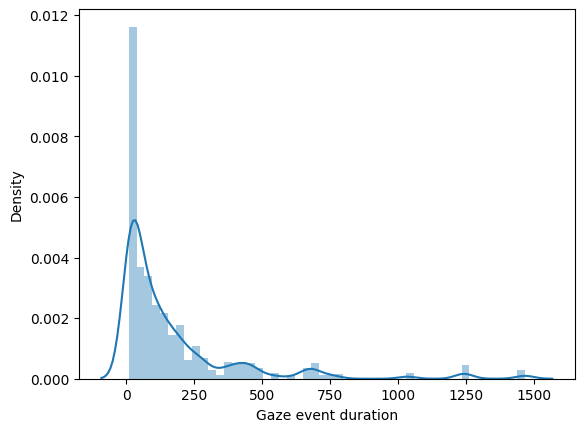

In [30]:
#Gaze event duration
sns.distplot(demo_data['Gaze event duration'])

'Gaze event duration' as we can observe is a highly right-skewed distribution. It will be retained to see how it affects the empathy score.

In [31]:
#Gaze point X and Gaze point Y
demo_data['Gaze point X'], demo_data['Gaze point Y']

(3082       NaN
 3083       NaN
 3084     962.0
 3085     962.0
 3086     962.0
          ...  
 10543    462.0
 10544    482.0
 10545    480.0
 10546    529.0
 10547      NaN
 Name: Gaze point X, Length: 22160, dtype: float64,
 3082       NaN
 3083       NaN
 3084     346.0
 3085     350.0
 3086     346.0
          ...  
 10543    201.0
 10544    218.0
 10545    213.0
 10546    217.0
 10547      NaN
 Name: Gaze point Y, Length: 22160, dtype: float64)

'Gaze point X' is the mean of the columns 'Gaze point left X' and 'Gaze point right X'. 'Gaze point Y' is the mean of the columns 'Gaze point left Y' and 'Gaze point right Y'. Hence, the columns 'Gaze point left X' ,'Gaze point right X', 'Gaze point left Y' and 'Gaze point right Y' can be dropped as that information is covered.

In the current approach, the data will be merged to have one row per trial of each participant. Hence, we are deleting the columns that have a DASC and MCS coordinate system data. 

'Pupil diameter left' and 'Pupil diameter right' will be rretained as they are important indicators of empathy. 

#### After analysis, the columns we will be retaining are "Computer timestamp", "Participant name", 'Recording name','Gaze point X','Gaze point Y', 'Pupil diameter left', 'Pupil diameter right', 'Eye movement type', 'Gaze event duration', 'Eye movement type index'. Only these columns will be imported from the entire dataset for all the participants. 

### Importing the entire dataset as a disctionary of datasets

In [32]:
data = merge_csv_dict(r"C:\Users\vk22372\EyeT")

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2855751044.py:7: DtypeWarning: Columns (34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data[file.split('participant')[1]] = pd.read_csv(os.path.join(directory, file), usecols=["Computer timestamp", "Participant name", 'Recording name','Gaze point X','Gaze point Y', 'Pupil diameter left', 'Pupil diameter right', 'Eye movement type', 'Gaze event duration', 'Eye movement type index'])
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2855751044.py:7: DtypeWarning: Columns (34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data[file.split('participant')[1]] = pd.read_csv(os.path.join(directory, file), usecols=["Computer timestamp", "Participant name", 'Recording name','Gaze point X','Gaze point Y', 'Pupil diameter left', 'Pupil diameter right', 'Eye movement type', 'Gaze event duration', 'Eye movement type index'])
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\28557

In [33]:
temp = data

In [34]:
keys = data.keys()
data['_11_trial_0.csv']

,Computer timestamp,Participant name,Recording name,Gaze point X,Gaze point Y,Pupil diameter left,Pupil diameter right,Eye movement type,Gaze event duration,Eye movement type index
0,512092386,Participant0001,Recording1,NaN,NaN,NaN,NaN,Fixation,117.0,64.0
1,512092386,Participant0001,Recording1,NaN,NaN,NaN,NaN,Fixation,117.0,64.0
2,512099191,Participant0001,Recording1,962.0,346.0,NaN,NaN,Fixation,117.0,64.0
3,512107520,Participant0001,Recording1,962.0,350.0,NaN,NaN,Fixation,117.0,64.0
4,512115853,Participant0001,Recording1,962.0,346.0,"3,21","3,14",Fixation,117.0,64.0
...,...,...,...,...,...,...,...,...,...,...
7461,572066018,Participant0001,Recording1,462.0,201.0,NaN,NaN,Fixation,75.0,259.0
7462,572074415,Participant0001,Recording1,482.0,218.0,NaN,NaN,Fixation,75.0,259.0
7463,572082685,Participant0001,Recording1,480.0,213.0,"2,92","2,93",Fixation,75.0,259.0
7464,572091054,Participant0001,Recording1,529.0,217.0,NaN,NaN,Fixation,75.0,259.0


Based on the analysis carried out, the preprocessing of the data has been automated. Code for the function pre_pros function is above.

In [36]:
for df in keys :
    data[df] = pre_pros(data[df])

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated an

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated an

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated an

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated an

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i][-2:]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\4048416474.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.get_dummies(df, columns=col)
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\1280764481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].split('g')[1]
C:\Users\vk22372\AppData\Local\Temp\ipykernel_2012\2107401625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

In [37]:
data['_3_trial_13.csv']

,index,Computer timestamp,Participant,Recording name,Gaze point X,Gaze point Y,Pupil diameter left,Pupil diameter right,Gaze event duration,Eye movement type index,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_EyesNotFound,Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Gaze event duration - Max
0,0,1221666122,3,14,NaN,NaN,NaN,NaN,50.0,38.0,0.927733,0.886305,1.012267,1.043695,0,5778,6748,5065,475.0
1,1,1221666122,3,14,NaN,NaN,NaN,NaN,50.0,38.0,0.927733,0.886305,1.012267,1.043695,0,5778,6748,5065,475.0
2,2,1221667836,3,14,1507.0,1085.0,NaN,NaN,50.0,38.0,0.927733,0.886305,1.012267,1.043695,0,5778,6748,5065,475.0
3,3,1221676182,3,14,1693.0,1084.0,3.23,3.30,50.0,38.0,0.927733,0.886305,1.012267,1.043695,0,5778,6748,5065,475.0
4,4,1221684521,3,14,1746.0,1069.0,NaN,NaN,50.0,38.0,0.927733,0.886305,1.012267,1.043695,0,5778,6748,5065,475.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18854,18854,1378005744,3,14,2066.0,635.0,NaN,NaN,58.0,2176.0,0.927733,0.886305,1.012267,1.043695,0,5778,6748,5065,475.0
18855,18855,1378013987,3,14,2062.0,642.0,3.24,3.06,58.0,2176.0,0.927733,0.886305,1.012267,1.043695,0,5778,6748,5065,475.0
18856,18856,1378021450,3,14,NaN,NaN,NaN,NaN,NaN,NaN,0.927733,0.886305,1.012267,1.043695,0,5778,6748,5065,475.0
18857,18857,1378021450,3,14,NaN,NaN,NaN,NaN,NaN,NaN,0.927733,0.886305,1.012267,1.043695,0,5778,6748,5065,475.0


In [39]:
trials_data = pd.DataFrame()


In [40]:
i=0
for df in keys:
    trials_data = pd.concat([trials_data, compress_trials(data[df],i)])
    i += 1

In [41]:
trials_data

,Participant,Recording name,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified
0,1.0,1.0,1070.355771,253.597742,1242.0,0.404153,0.589454,1.105847,0.910546,3959.0,1996.0,1115.0
1,1.0,2.0,965.955342,306.260339,717.0,0.472800,0.631475,0.637200,0.728525,4235.0,1909.0,842.0
2,3.0,11.0,1017.325455,555.689808,500.0,0.916326,0.548080,0.893674,0.771920,2070.0,2232.0,1920.0
3,3.0,12.0,984.012235,588.452621,350.0,0.900668,0.813724,1.069332,0.886276,3194.0,4429.0,4043.0
4,3.0,13.0,1005.079682,534.013693,325.0,1.114668,0.872575,1.005332,0.867425,2605.0,4969.0,3920.0
...,...,...,...,...,...,...,...,...,...,...,...,...
497,56.0,4.0,982.199465,636.944157,1067.0,0.609184,1.167508,1.080816,1.342492,1906.0,990.0,2747.0
498,58.0,2.0,937.805840,427.840598,2033.0,1.939853,1.530958,0.960147,1.049042,5636.0,913.0,501.0
499,58.0,4.0,943.514611,419.835007,2500.0,1.963222,2.037256,0.926778,1.042744,4925.0,754.0,1048.0
500,60.0,2.0,878.143282,421.078113,1433.0,0.419122,0.632128,0.760878,1.457872,5294.0,997.0,496.0


### Approach 1 - Building different models for test group and control group

In [42]:
#separating test group participants and the control group participants
control_group = trials_data[trials_data['Participant'] %2 != 0]
test_group = trials_data[trials_data['Participant'] %2 == 0]

In [43]:
test_group.head()

,Participant,Recording name,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified
360,10.0,1.0,971.247027,441.096289,1017.0,0.872613,2.897901,0.827387,1.042099,5392.0,1164.0,466.0
361,10.0,2.0,978.398370,484.556360,3476.0,1.630469,2.920098,0.979531,0.829902,5283.0,1097.0,316.0
362,10.0,3.0,998.712701,554.162540,6567.0,2.002562,2.109127,0.907438,0.750873,4444.0,1252.0,572.0
363,10.0,4.0,1003.353020,587.964254,12156.0,1.269191,0.642110,0.960809,0.967890,3389.0,849.0,294.0
364,14.0,2.0,1016.897923,481.736213,575.0,0.841228,0.882427,0.658772,1.117573,1182.0,485.0,5149.0


In [44]:
control_group.head()

,Participant,Recording name,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified
0,1.0,1.0,1070.355771,253.597742,1242.0,0.404153,0.589454,1.105847,0.910546,3959.0,1996.0,1115.0
1,1.0,2.0,965.955342,306.260339,717.0,0.472800,0.631475,0.637200,0.728525,4235.0,1909.0,842.0
2,3.0,11.0,1017.325455,555.689808,500.0,0.916326,0.548080,0.893674,0.771920,2070.0,2232.0,1920.0
3,3.0,12.0,984.012235,588.452621,350.0,0.900668,0.813724,1.069332,0.886276,3194.0,4429.0,4043.0
4,3.0,13.0,1005.079682,534.013693,325.0,1.114668,0.872575,1.005332,0.867425,2605.0,4969.0,3920.0


In [45]:
test_group.shape

(142, 12)

In [46]:
control_group.shape

(360, 12)

#### The target variable 'Empathy score' should be attached to the above dataframe.

In [47]:
test_group = test_group.merge(emp_score, on='Participant', how='inner')
control_group = control_group.merge(emp_score, on='Participant', how='inner')

In [48]:
test_group.head()

,Participant,Recording name,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Q_IA_og,Q_IA_ext,Q_IB_og,Q_IB_ext,Class
0,10.0,1.0,971.247027,441.096289,1017.0,0.872613,2.897901,0.827387,1.042099,5392.0,1164.0,466.0,82,104,80,102,2
1,10.0,2.0,978.398370,484.556360,3476.0,1.630469,2.920098,0.979531,0.829902,5283.0,1097.0,316.0,82,104,80,102,2
2,10.0,3.0,998.712701,554.162540,6567.0,2.002562,2.109127,0.907438,0.750873,4444.0,1252.0,572.0,82,104,80,102,2
3,10.0,4.0,1003.353020,587.964254,12156.0,1.269191,0.642110,0.960809,0.967890,3389.0,849.0,294.0,82,104,80,102,2
4,14.0,2.0,1016.897923,481.736213,575.0,0.841228,0.882427,0.658772,1.117573,1182.0,485.0,5149.0,109,135,102,128,4


We are going to retain only Q_IB_ext for the test group

In [49]:
#dropping the columns that are not required
cols = {'Participant','Recording name', 'Q_IA_og', 'Q_IA_ext', 'Q_IB_og', 'Class'}
test_group = test_group.drop(cols, axis=1)

In [50]:
test_group.head()

,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Q_IB_ext
0,971.247027,441.096289,1017.0,0.872613,2.897901,0.827387,1.042099,5392.0,1164.0,466.0,102
1,978.398370,484.556360,3476.0,1.630469,2.920098,0.979531,0.829902,5283.0,1097.0,316.0,102
2,998.712701,554.162540,6567.0,2.002562,2.109127,0.907438,0.750873,4444.0,1252.0,572.0,102
3,1003.353020,587.964254,12156.0,1.269191,0.642110,0.960809,0.967890,3389.0,849.0,294.0,102
4,1016.897923,481.736213,575.0,0.841228,0.882427,0.658772,1.117573,1182.0,485.0,5149.0,128


In [51]:
#dropping the columns that are not required, we are going to retain only Q_IA_ext
cols = {'Participant','Recording name', 'Q_IA_og', 'Q_IA_ext', 'Q_IB_ext', 'Class'}
control_group = control_group.drop(cols, axis=1)

In [52]:
control_group.head()

,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Q_IB_og
0,1070.355771,253.597742,1242.0,0.404153,0.589454,1.105847,0.910546,3959.0,1996.0,1115.0,101
1,965.955342,306.260339,717.0,0.472800,0.631475,0.637200,0.728525,4235.0,1909.0,842.0,101
2,945.398773,320.944357,600.0,0.340705,0.361400,0.479295,0.738600,3987.0,2047.0,992.0,101
3,956.205589,382.697346,608.0,0.472690,0.499765,0.527310,0.510235,7003.0,3057.0,1417.0,101
4,980.634064,326.117525,633.0,0.548290,0.490739,0.471710,0.459261,4903.0,2068.0,807.0,101


### Test Group model

In [145]:
X = test_group.drop(['Q_IB_ext'], axis=1 )

Y = test_group['Q_IB_ext']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1, random_state=1)

In [146]:
X_train.shape

(127, 10)

In [147]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
#control_group_scaled = scaler.fit_transform(control_group)
#final_group_scaled = scaler.fit_transform(final_group)

#### Random Forest Regressor model for the Test group

In [148]:
rf_model1 = RandomForestRegressor()
rf_model1.fit(X_train, Y_train)

RandomForestRegressor()

In [149]:
#Cross-val score
kf = KFold(n_splits=7, random_state=None)
results=cross_val_score(rf_model1,X_train,Y_train,cv=kf)
print('Cross-Val accuracy - ',np.mean(results))
rf_model1.fit(X_train, Y_train)

Cross-Val accuracy -  0.39137239422951015


RandomForestRegressor()

In [150]:
#Test Accuracy
print('Test score - ',rf_model1.score(X_test, Y_test))

Test score -  0.4991021404262942


In [151]:
Y_pred = rf_model1.predict(X_test)
#calculate RMSE
sqrt(mean_squared_error(Y_test, Y_pred))

12.212589678961079

#### Gradient Boost Regressor model for the Test group

In [152]:
gb_model1 = GradientBoostingRegressor()
gb_model1.fit(X_train, Y_train)

GradientBoostingRegressor()

In [153]:
#Cross-val score
kf = KFold(n_splits=7, random_state=None)
results=cross_val_score(gb_model1,X_train,Y_train,cv=kf)
print('Cross-Val accuracy - ',np.mean(results))
gb_model1.fit(X_train, Y_train)

Cross-Val accuracy -  0.3825785104211669


GradientBoostingRegressor()

In [154]:
print('Test score - ',gb_model1.score(X_test, Y_test))

Test score -  0.5660110517332703


In [155]:
Y_pred = gb_model1.predict(X_test)
#calculate RMSE
sqrt(mean_squared_error(Y_test, Y_pred))

11.36769762246962

### Control Group model


In [156]:
X = control_group.drop(['Q_IB_og'], axis=1 )

Y = control_group['Q_IB_og']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1, random_state=1)

In [157]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
#control_group_scaled = scaler.fit_transform(control_group)
#final_group_scaled = scaler.fit_transform(final_group)

#### Random Forest Regressor model for the Control group

In [158]:
rf_model2 = RandomForestRegressor()
rf_model2.fit(X_train, Y_train)

RandomForestRegressor()

In [159]:
#Cross-val score
kf = KFold(n_splits=10, random_state=None)
results=cross_val_score(rf_model2,X_train,Y_train,cv=kf)
print('Cross-Val accuracy - ',np.mean(results))
rf_model2.fit(X_train, Y_train)

Cross-Val accuracy -  0.6274462639764553


RandomForestRegressor()

In [160]:
print('Test score - ',rf_model2.score(X_test, Y_test))

Test score -  0.7951350038023546


In [161]:
Y_pred = rf_model2.predict(X_test)
#calculate RMSE
sqrt(mean_squared_error(Y_test, Y_pred))

4.05231895201857

#### Gradient Boost Regressor model for the Control group

In [163]:
gb_model2 = GradientBoostingRegressor()
gb_model2.fit(X_train, Y_train)

GradientBoostingRegressor()

In [164]:
#Cross-val score
kf = KFold(n_splits=10, random_state=None)
results=cross_val_score(gb_model2,X_train,Y_train,cv=kf)
print('Cross-Val accuracy - ',np.mean(results))
gb_model2.fit(X_train, Y_train)

Cross-Val accuracy -  0.5686362525108876


GradientBoostingRegressor()

In [165]:
print('Test score - ',gb_model2.score(X_test, Y_test))

Test score -  0.8166571189861176


In [166]:
Y_pred = gb_model2.predict(X_test)
#calculate RMSE
sqrt(mean_squared_error(Y_test, Y_pred))

3.8335556002757034

### Another approach - Classifying the empathy scores into 4 categories 

In [167]:
trials_data.head()

,Participant,Recording name,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified
0,1.0,1.0,1070.355771,253.597742,1242.0,0.404153,0.589454,1.105847,0.910546,3959.0,1996.0,1115.0
1,1.0,2.0,965.955342,306.260339,717.0,0.472800,0.631475,0.637200,0.728525,4235.0,1909.0,842.0
2,3.0,11.0,1017.325455,555.689808,500.0,0.916326,0.548080,0.893674,0.771920,2070.0,2232.0,1920.0
3,3.0,12.0,984.012235,588.452621,350.0,0.900668,0.813724,1.069332,0.886276,3194.0,4429.0,4043.0
4,3.0,13.0,1005.079682,534.013693,325.0,1.114668,0.872575,1.005332,0.867425,2605.0,4969.0,3920.0


In [168]:
trials_data_emp = trials_data.merge(emp_score, on='Participant', how='inner')
trials_data_emp

,Participant,Recording name,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Q_IA_og,Q_IA_ext,Q_IB_og,Q_IB_ext,Class
0,1.0,1.0,1070.355771,253.597742,1242.0,0.404153,0.589454,1.105847,0.910546,3959.0,1996.0,1115.0,100,125,101,127,4
1,1.0,2.0,965.955342,306.260339,717.0,0.472800,0.631475,0.637200,0.728525,4235.0,1909.0,842.0,100,125,101,127,4
2,1.0,3.0,945.398773,320.944357,600.0,0.340705,0.361400,0.479295,0.738600,3987.0,2047.0,992.0,100,125,101,127,4
3,1.0,4.0,956.205589,382.697346,608.0,0.472690,0.499765,0.527310,0.510235,7003.0,3057.0,1417.0,100,125,101,127,4
4,1.0,5.0,980.634064,326.117525,633.0,0.548290,0.490739,0.471710,0.459261,4903.0,2068.0,807.0,100,125,101,127,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,20.0,4.0,873.097778,348.956349,4048.0,1.205493,1.016968,1.304507,1.303032,4504.0,1100.0,805.0,95,117,106,132,4
498,22.0,1.0,843.135480,489.088460,1458.0,0.460149,0.477857,1.649851,1.052143,4097.0,966.0,1278.0,89,108,95,121,3
499,22.0,2.0,778.052670,444.224280,1521.0,0.774306,0.555542,1.495694,1.354458,4200.0,1245.0,1613.0,89,108,95,121,3
500,22.0,3.0,772.105281,409.056004,1138.0,0.570868,0.516661,1.469132,1.253339,3332.0,1063.0,1706.0,89,108,95,121,3


In [184]:
corr = trials_data_emp.corr()
corr.style.background_gradient(cmap='coolwarm')

,Gaze point X,Gaze point Y,Gaze event duration - Max,Left pupil (max-mean),Right pupil (max-mean),Left pupil (mean-min),Right pupil (mean-min),Eye movement type_Fixation,Eye movement type_Saccade,Eye movement type_Unclassified,Class
Gaze point X,1.000000,-0.106872,-0.103869,0.029393,-0.067179,-0.071125,-0.167768,-0.229583,-0.021264,-0.164812,0.119874
Gaze point Y,-0.106872,1.000000,-0.020912,0.250030,0.261752,0.170793,0.145333,-0.019317,0.063909,0.222915,-0.220726
Gaze event duration - Max,-0.103869,-0.020912,1.000000,0.167313,0.082141,0.100410,0.074663,0.273780,0.062234,-0.013769,-0.183672
Left pupil (max-mean),0.029393,0.250030,0.167313,1.000000,0.803982,0.498456,0.419893,0.136145,0.036894,0.094245,-0.168134
Right pupil (max-mean),-0.067179,0.261752,0.082141,0.803982,1.000000,0.521663,0.434296,0.138169,0.020686,0.153497,-0.149617
Left pupil (mean-min),-0.071125,0.170793,0.100410,0.498456,0.521663,1.000000,0.665176,0.037342,-0.041117,0.162821,-0.121955
Right pupil (mean-min),-0.167768,0.145333,0.074663,0.419893,0.434296,0.665176,1.000000,0.076337,-0.003441,0.203244,-0.113830
Eye movement type_Fixation,-0.229583,-0.019317,0.273780,0.136145,0.138169,0.037342,0.076337,1.000000,0.647033,0.015541,-0.014723
Eye movement type_Saccade,-0.021264,0.063909,0.062234,0.036894,0.020686,-0.041117,-0.003441,0.647033,1.000000,0.367924,0.156338
Eye movement type_Unclassified,-0.164812,0.222915,-0.013769,0.094245,0.153497,0.162821,0.203244,0.015541,0.367924,1.000000,0.171650


In [169]:
#We are going to retain only Class amongst the empathy scores as the target variable
#dropping the columns that are not required
cols = {'Participant','Recording name', 'Q_IA_og', 'Q_IA_ext', 'Q_IB_og', 'Q_IB_ext'}
trials_data_emp = trials_data_emp.drop(cols, axis=1)

### Classification model

In [170]:
X = trials_data_emp.drop(['Class'], axis=1 )

Y = trials_data_emp['Class']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1, random_state=1)

In [171]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Random Forest Classifier

In [172]:
rf_cl = RandomForestClassifier()
rf_cl.fit(X_train, Y_train)

RandomForestClassifier()

In [173]:
#Cross-val score
kf = KFold(n_splits=10, random_state=None)
results=cross_val_score(rf_cl,X_train,Y_train,cv=kf)
print('Cross-Val accuracy - ',np.mean(results))
rf_cl.fit(X_train, Y_train)

Cross-Val accuracy -  0.8048309178743962


RandomForestClassifier()

In [174]:
Y_predict = rf_cl.predict(X_test)
print('Test score - ',rf_cl.score(X_test, Y_test))

Test score -  0.803921568627451


In [175]:
pd.DataFrame(data={'Predictions': Y_predict, 'Actual': Y_test})

,Predictions,Actual
306,3,3
342,3,3
47,4,4
67,3,3
376,3,3
...,...,...
497,2,4
358,3,3
372,3,3
102,3,3


#### Gradient Boosting Classifier

In [176]:
gb_cl = GradientBoostingClassifier()
gb_cl.fit(X_train, Y_train) 

GradientBoostingClassifier()

In [177]:
#Cross-val score
kf = KFold(n_splits=10, random_state=None)
results=cross_val_score(gb_cl,X_train,Y_train,cv=kf)
print('Cross-Val accuracy - ',np.mean(results))
gb_cl.fit(X_train, Y_train)

Cross-Val accuracy -  0.7871497584541063


GradientBoostingClassifier()

In [178]:
Y_predict = gb_cl.predict(X_test)

print('Test score - ', gb_cl.score(X_test, Y_test))

Test score -  0.7647058823529411


In [179]:
pd.DataFrame(data={'Predictions': Y_predict, 'Actual': Y_test})

,Predictions,Actual
306,3,3
342,3,3
47,4,4
67,3,3
376,3,3
...,...,...
497,2,4
358,3,3
372,3,3
102,3,3


### Conclusion 
The task of this project is to attempt to investigate how effectively empathy of an individual can be predicted using his/her eye tracking data. As observed, the regression models struggle to predict empathy on a continuous scale with just the eye-tracking data that is available. However, empathy is something that is subjective and which cannot be assigned a very accurate number on a continuous scale. So, the other approach is to convert the continous scale into 4 classes and build a classification model and investigate how effectively we can classify the participants into their respective empathy classes. This might be a better approach, as evidenced by the consistant train and test scores achieved by both Random Forest Classifier and the Gradient Boosting Classifier. 

************END****************